# XGBoost-from-Prediction
This notebook shows an example of fitting a linear model to a dataset then boosting with trees on top of that model.

## Load libraries

In [1]:
import pip
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
%matplotlib inline

## Get modelling dataset

Download car insurance dataset from http://www.acst.mq.edu.au/GLMsforInsuranceData.

In [2]:
site = 'http://www.businessandeconomics.mq.edu.au/our_departments/'
site_subfolder = 'Applied_Finance_and_Actuarial_Studies/acst_docs/glms_for_insurance_data/data/'
file_url = site + site_subfolder + 'car.csv'
data = pd.read_csv(file_url)
data.head()

,veh_value,exposure,clm,numclaims,claimcst0,veh_body,veh_age,gender,area,agecat,_OBSTAT_
0,1.06,0.303901,0,0,0.0,HBACK,3,F,C,2,01101 0 0 0
1,1.03,0.648871,0,0,0.0,HBACK,2,F,A,4,01101 0 0 0
2,3.26,0.569473,0,0,0.0,UTE,2,F,E,2,01101 0 0 0
3,4.14,0.317591,0,0,0.0,STNWG,2,F,D,2,01101 0 0 0
4,0.72,0.648871,0,0,0.0,HBACK,4,F,C,2,01101 0 0 0


Convert nominal variables to dummy variables.

In [3]:
dummy_cols = []
for col in ['gender', 'area', 'veh_body']:
    dummies = pd.get_dummies(data[col])
    dummies.columns = [col + '_' + lvl for lvl in dummies.columns.values]
    dummy_cols.extend(dummies.columns.values)
    data[dummies.columns.values] = dummies
data.head()

,veh_value,exposure,clm,numclaims,claimcst0,veh_body,veh_age,gender,area,agecat,...,veh_body_HBACK,veh_body_HDTOP,veh_body_MCARA,veh_body_MIBUS,veh_body_PANVN,veh_body_RDSTR,veh_body_SEDAN,veh_body_STNWG,veh_body_TRUCK,veh_body_UTE
0,1.06,0.303901,0,0,0.0,HBACK,3,F,C,2,...,1,0,0,0,0,0,0,0,0,0
1,1.03,0.648871,0,0,0.0,HBACK,2,F,A,4,...,1,0,0,0,0,0,0,0,0,0
2,3.26,0.569473,0,0,0.0,UTE,2,F,E,2,...,0,0,0,0,0,0,0,0,0,1
3,4.14,0.317591,0,0,0.0,STNWG,2,F,D,2,...,0,0,0,0,0,0,0,1,0,0
4,0.72,0.648871,0,0,0.0,HBACK,4,F,C,2,...,1,0,0,0,0,0,0,0,0,0


## Build a logistic regression model initially

In [4]:
expl_cols = ['veh_value', 'veh_age', 'agecat'] + dummy_cols
lr = LogisticRegression()
lr.fit(data[expl_cols], data['clm'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Get predicted probabilites and predictions on the link scale before the logit function is applied.

In [6]:
preds_proba = lr.predict_proba(data[expl_cols])[:, 1]
preds_link = np.log(preds_proba / (1 - preds_proba))
print('predicted probabilities:', preds_proba[:5])
print('predictions link scale:', preds_link[:5])

predicted probabilities: [0.07414059 0.06192531 0.06449074 0.07752208 0.07199259]
predictions link scale: [-2.52475925 -2.71790052 -2.67456934 -2.47650065 -2.55647653]


Plot shape of the predictions from the logistic regression.

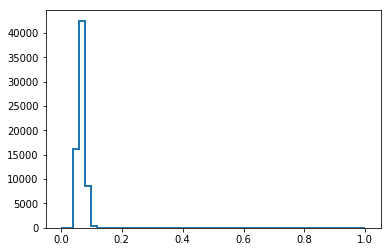

In [7]:
plt.figure()
n, bins, patches = plt.hist(preds_proba, 
                            range = (0, 1), 
                            bins = 50, 
                            histtype = "step", 
                            lw = 2,
                            fill = False)

## Build an xgboost model on top of the logistic regression

In [8]:
dtrain = xgb.DMatrix(data = data[expl_cols], 
                     label = data['clm'])
# add the predictions on the link scale as the base margin
dtrain.set_base_margin(preds_link)

In [9]:
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic'}
bst = xgb.train(param, dtrain, 50)
ptrain_xgb = bst.predict(dtrain)

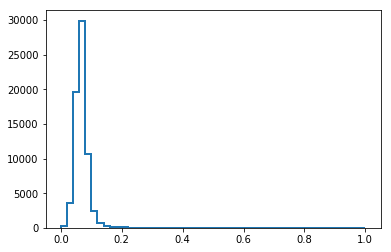

In [10]:
plt.figure()
n, bins, patches = plt.hist(ptrain_xgb, 
                            range = (0, 1), 
                            bins = 50, 
                            histtype = "step", 
                            lw = 2,
                            fill = False)

## Functions to print package info

In [11]:
def get_pkg_version(pkg_name, depth = 0):
    """Function to print package version and dependency versions."""
    x = [[pkg.key, pkg.version, pkg.requires()] \
         for pkg in pip.get_installed_distributions() if pkg.key in [pkg_name]][0]
    print('  ' * depth, x[:2])
    if (len(x[2]) > 0):
        for i in range(len(x[2])):
            get_pkg_version(x[2][i].key, depth + 1)

def print_pkg_info(pkg_names):
    """Function to call get_pkg_version for multiple packages."""
    for name in pkg_names:
        get_pkg_version(name)

## Record packages used in analysis

In [12]:
print_pkg_info(['xgboost', 'pandas', 'numpy', 'scikit-learn', 'matplotlib', 'pip'])

 ['xgboost', '0.7']
   ['numpy', '1.14.0']
   ['scipy', '0.19.1']
 ['pandas', '0.20.3']
   ['python-dateutil', '2.6.1']
     ['six', '1.11.0']
   ['pytz', '2017.2']
   ['numpy', '1.14.0']
 ['numpy', '1.14.0']
 ['scikit-learn', '0.19.1']
 ['matplotlib', '2.1.0']
   ['numpy', '1.14.0']
   ['six', '1.11.0']
   ['python-dateutil', '2.6.1']
     ['six', '1.11.0']
   ['pytz', '2017.2']
   ['cycler', '0.10.0']
     ['six', '1.11.0']
   ['pyparsing', '2.2.0']
 ['pip', '9.0.1']
